Random Seed:  999
Files already downloaded and verified
Files already downloaded and verified
Feature batch shape: torch.Size([128, 3, 32, 32])
Labels batch shape: torch.Size([128])


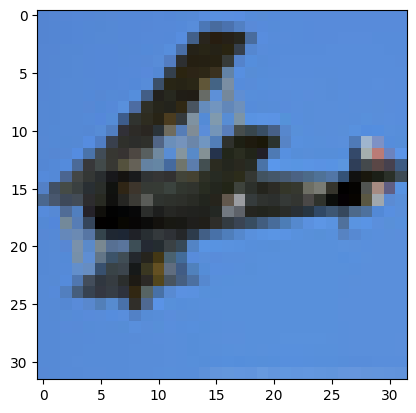

Label: 0
Feature batch shape: torch.Size([128, 3, 32, 32])
Labels batch shape: torch.Size([128])


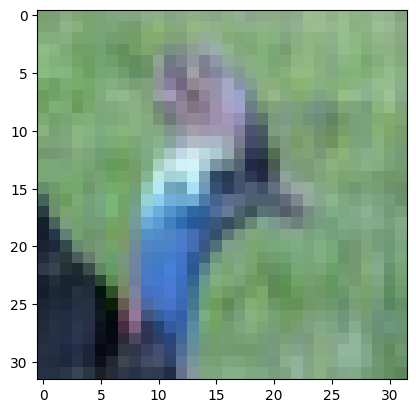

Label: 2


In [2]:
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
from torch.utils.data import dataset
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results
os.makedirs("images", exist_ok=True)
img_size = 32
batch_size = 128

# Use the custom dataset in the data loader
train_dataloader = torch.utils.data.DataLoader(
    dset.CIFAR10(
        "../../data/cifar10",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(img_size),
                               transforms.CenterCrop(img_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
        ),
    ),
    batch_size=batch_size,
    shuffle=True,
)
# Use the custom dataset in the data loader
test_dataloader = torch.utils.data.DataLoader(
    dset.CIFAR10(
        "../../data/cifar10",
        train=False,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(img_size),
                               transforms.CenterCrop(img_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
        ),
    ),
    batch_size=batch_size,
    shuffle=True,
)
# Train data example
train_dataloader.batch_size
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
img = img.permute(1, 2, 0)  # Change the shape to (32, 32, 3)
img = (img + 1) / 2  # Adjust the values to [0, 1] range
plt.imshow(img)
plt.show()
print(f"Label: {label}")

# Test data example
test_dataloader.batch_size
test_features, test_labels = next(iter(test_dataloader))
print(f"Feature batch shape: {test_features.size()}")
print(f"Labels batch shape: {test_labels.size()}")
img = test_features[0].squeeze()
label = test_labels[0]
img = img.permute(1, 2, 0)  # Change the shape to (32, 32, 3)
img = (img + 1) / 2  # Adjust the values to [0, 1] range
plt.imshow(img)
plt.show()
print(f"Label: {label}")

In [3]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 32 x 32
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 16 x 16
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 8 x 8
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 4 x 4
            nn.Conv2d(256, 1, 4, 1, 0, bias=False),
            
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)
    
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(100, 256, 4, 1, 0, bias=False),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 32 x 32
        )

    def forward(self, input):
        return self.main(input)
# Create Discriminator and Generator instances on CUDA device
D = Discriminator().to(device)
G = Generator().to(device)
# Initialize optimizer for Discriminator and Generator
optimizerD = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Loss function
criterion = nn.BCELoss()
# Print info about the models
print(D)
print(G)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (10): Sigmoid()
  )
)
Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(256, 12

Starting Training Loop...
[0/15][0/391]	Loss_D: 1.5123	Loss_G: 1.4281	D(x): 0.5690	D(G(z)): 0.5994 / 0.2496
[0/15][50/391]	Loss_D: 0.3034	Loss_G: 4.6457	D(x): 0.8625	D(G(z)): 0.1331 / 0.0120
[0/15][100/391]	Loss_D: 0.3207	Loss_G: 4.9784	D(x): 0.8910	D(G(z)): 0.1641 / 0.0083
[0/15][150/391]	Loss_D: 0.4436	Loss_G: 3.1653	D(x): 0.7429	D(G(z)): 0.0669 / 0.0535
[0/15][200/391]	Loss_D: 0.5111	Loss_G: 5.0091	D(x): 0.8935	D(G(z)): 0.3073 / 0.0087
[0/15][250/391]	Loss_D: 0.3810	Loss_G: 3.4200	D(x): 0.8087	D(G(z)): 0.1323 / 0.0414
[0/15][300/391]	Loss_D: 0.4397	Loss_G: 2.8831	D(x): 0.7456	D(G(z)): 0.0858 / 0.0695
[0/15][350/391]	Loss_D: 0.3783	Loss_G: 3.2176	D(x): 0.8024	D(G(z)): 0.1087 / 0.0519
[1/15][0/391]	Loss_D: 0.3489	Loss_G: 5.3190	D(x): 0.9322	D(G(z)): 0.2270 / 0.0080
[1/15][50/391]	Loss_D: 0.2303	Loss_G: 3.9475	D(x): 0.9129	D(G(z)): 0.1158 / 0.0278
[1/15][100/391]	Loss_D: 0.4953	Loss_G: 4.7255	D(x): 0.9037	D(G(z)): 0.2846 / 0.0130
[1/15][150/391]	Loss_D: 0.8711	Loss_G: 1.8523	D(x): 0.49

MovieWriter imagemagick unavailable; using Pillow instead.


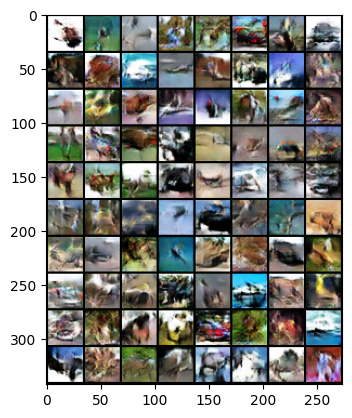

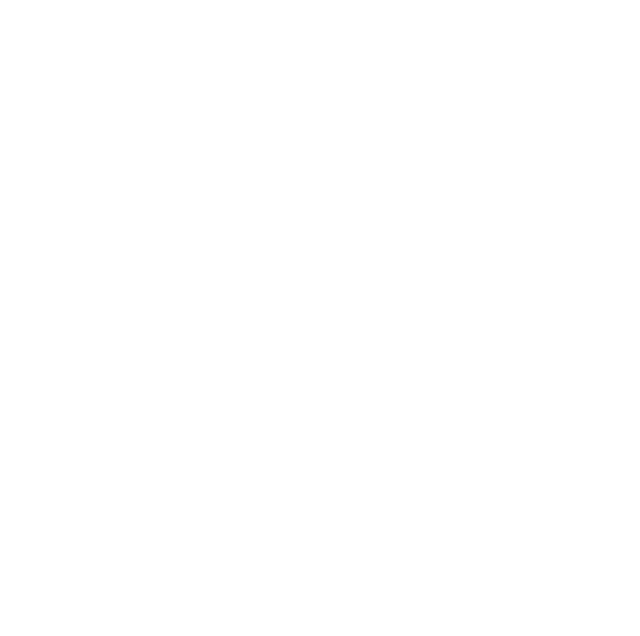

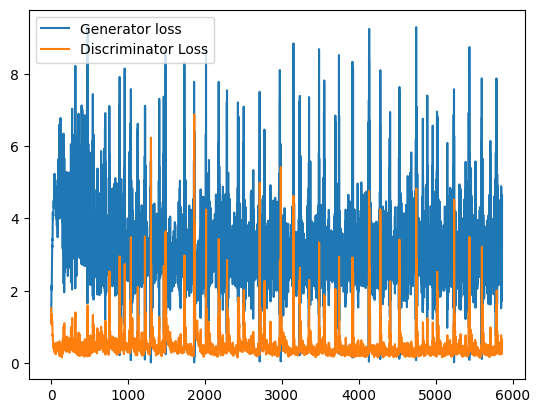

In [4]:
# Training Loop
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0
num_epochs = 15
# Training Loop
print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(train_dataloader, 0):
        # Train with all-real batch
        D.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), 1, dtype=torch.float32,device=device)
        output = D(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()
        # Train with all-fake batch
        noise = torch.randn(b_size, 100, 1, 1, device=device)
        fake = G(noise)
        label.fill_(0)
        output = D(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()
        # Update G network
        G.zero_grad()
        label.fill_(1)  # fake labels are real for generator cost
        output = D(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()
        # Output training stats
        if i % 50 == 0:
            print(f"[{epoch}/{num_epochs}][{i}/{len(train_dataloader)}]\t"
                  f"Loss_D: {errD.item():.4f}\tLoss_G: {errG.item():.4f}\t"
                  f"D(x): {D_x:.4f}\tD(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}")
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs - 1) and (i == len(train_dataloader) - 1)):
            with torch.no_grad():
                fake = G(noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            # Save the images to images folder

            vutils.save_image(fake, f"images/fake_images_{iters}.png")
            # Save animation

        iters += 1
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
fig = plt.figure(figsize=(8,8))
plt.axis("off")


# Save the model
torch.save(G.state_dict(), "saved_model/generator.pth")
plt.figure()
# Plot the training losses
plt.plot(G_losses, label='Generator loss')
plt.plot(D_losses, label='Discriminator Loss')
plt.legend()
plt.savefig('loss.png')
plt.show()

Text(0.5, 1.0, 'Fake Images')

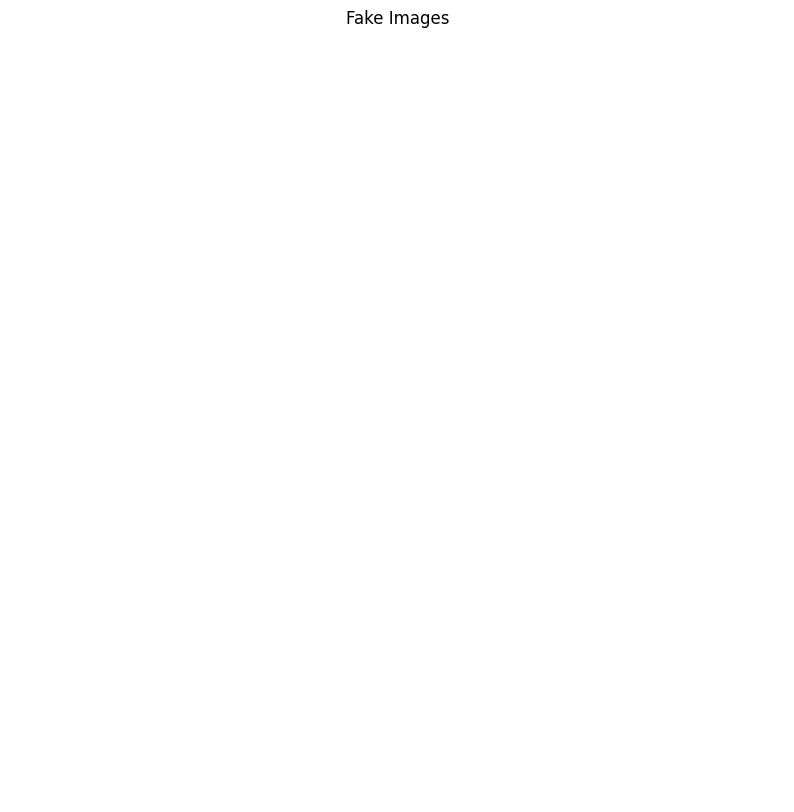

In [20]:
# Load the model
G = Generator().to(device)
G.load_state_dict(torch.load("saved_model/generator.pth"))
# Get random seed
fixed_noise = torch.randn(64, 100, 1, 1, device=device)
# Generate fake images
fake = G(fixed_noise)
# Plot the fake images
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(vutils.make_grid(fake.to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))
